In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle as skshuffle
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.autograd import Variable

In [2]:
'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


In [3]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        
        self.drop = nn.Dropout(0.2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        out = self.drop(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.drop(out)
        # Max pool 2 
        out = self.maxpool2(out)
        
        #out = self.drop(out)
        
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out


In [5]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.01)


In [6]:
iter = 0
pred_test_results = []
labels_test_results = []
loss_values = []
num_updates = 0
#correct = 0.0
for epoch in range(num_epochs):
    running_loss = 0.0
    batch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        
      
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        batch_loss += loss.item()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
    print("Epoch:", epoch+1, " Loss:", batch_loss/len(train_loader))
    loss_values.append(batch_loss/len(train_loader))

print("training ended")  
   


Epoch: 1  Loss: 0.726558465535442
Epoch: 2  Loss: 0.24772931336114803
Epoch: 3  Loss: 0.18098707284157475
Epoch: 4  Loss: 0.14883469561114906
Epoch: 5  Loss: 0.13027575596546134
Epoch: 6  Loss: 0.11796923249959945
Epoch: 7  Loss: 0.11000185648910701
Epoch: 8  Loss: 0.10316119848750532
Epoch: 9  Loss: 0.09906833892067274
Epoch: 10  Loss: 0.0958469091852506
training ended


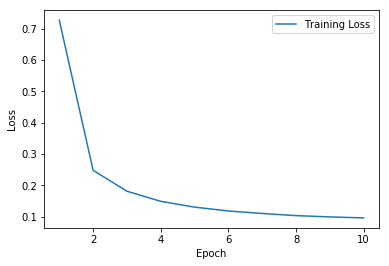

In [7]:
#plot the learning curve
plt.plot(np.arange(1,num_epochs + 1),loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [8]:
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader:
    
    if torch.cuda.is_available():
        images = Variable(images.cuda())
    else:
        images = Variable(images)
                
    # Forward pass only to get logits/output
    outputs = model(images)
                
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
                
    # Total number of labels
    total += labels.size(0)
                
              
    # Total correct predictions
    if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum()
    else:
        correct += (predicted == labels).sum()
            
accuracy = 100 * correct / total
print("Accuracy on total test data: {}%".format(accuracy.item()))    

Accuracy on total test data: 97%
